# Assignment 2

## Guidelines

> Remember that this is a code notebook - add an explanation of what you do using text boxes and markdown, and comment your code. Answers without explanations may get less points.
>
> If you re-use a substantial portion of code you find online, e.g on Stackoverflow, you need to add a link to it and make the borrowing explicit. The same applies of you take it and modify it, even substantially. There is nothing bad in doing that, providing you are acknowledging it and make it clear you know what you're doing.
>
> The **Generative AI policy** from the syllabus for the programming assignments applies. Generative AI can be used as a source of information in these assignments if properly referenced. You can use generative AI assistance for writing code, but you must reference the chat used as a source, just as if you would take from StackOverflow. In ChatGPT, you can make an URL to the information you obtained by clicking the "Share link to Chat" button and then "Copy Link". This allows you to cite the source of the information you use in your answer or code solution. Of course, as you know, GenAI tools are not always a reliable source and its answers are intransparantly drawn from other sources - it is recommended to cross-check its output with other sources or your own understanding of the topic.
> 
> For the explanations of what you do that you provide with each question, as well as for (sub)questions that ask about things like motivation of choices or your opinion, the answer to this must be conceptualized and written by yourself and not copied from a generative AI source.
>
> Make sure your notebooks have been run when you submit, as I won't run them myself. Submit both the `.ipynb` file along with an `.html` export of the same. Submit all necessary auxilliary files as well. Please compress your submission into a `.zip` archive. Only `.zip` files can be submitted.
> If you are using Google Colab, here is a tutorial for obtaining an HTML export: https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab .
>
> With Jupyter, you can simply export it as HTML through the File menu.

## Grading policy
> As follows:
>
> * 70 points for correctly completing the assignment.
>
> * 20 points for appropriately writing and organizing your code in terms of structure, readibility (also by humans), comments and minimal documentation. It is important to be concise but also to explain what you did and why, when not obvious. Feel free to re-use functions and variables from previous questions if that helps for structure and readability - you do not need to repeat previous steps for each question.
> 
> * 10 points for doing something extra, e.g., if you go beyond expectations (overall or on something specific). Some ideas for extras might be mentioned in the exercises, or you can come up with your own. You don't need to do them all to get the bonus. The sum of points is 90, doing (some of) the extras can bring you to 100, so the extras are not necessary to get an A.
> 

**The AUC code of conduct applies to this assignment: please only submit your own work and follow the instructions on referencing external sources above.**

---

# Introduction

In this assignment, you will build and compare vector models for measuring **semantic similarity**.

First, you are going to use different count-based methods to create these models. Secondly you are going to created dense, lower-dimensionality models from them. Thirdly, you are going to use prediction-based models as well.

Eventually, you are asked to assess the performance of these models against a human gold standard.

I recommend basing your code on the examples in the course notebooks on this topic.

---

# Corpus preparation (8 points)

## Question 1 (8 points)

Prepare for creating a distributional space by **counting and filtering** the surface co-occurrences in a symmetric ±5 word collocations span from the following corpus:

* A lemmatized version of the Reuters corpus (the choice of the lemmatizer is up to you). For this step, you might need a PoS-tagger: you are welcome to choose one yourself. In case you can't do PoS tagging on your own, you can use the following command to load the provided corpus in `data/reuters.pos` (uploaded as a `.zip` file, so first unzip it):

```python
with open("data/reuters.pos", "rb") as corpus_file:
    reuter_PoSTagged = pickle.load(corpus_file)
```

Remember to make motivated choices for the different strategies in building word vectors as described in class. Be explicit about:

1. what lemmas you want to describe (i.e., what will be your target vectors?);
2. how you want to describe them (i.e., what will be your contexts?);
3. what filtering strategy you are going to choose (i.e., what do you exclude?).

That means you should describe these things in text.

**Possible extra**

Actually create the space with these counts as values (i.e. make a vector with the counts, as in the subsequent questions where we put weighted counts in the vector).

In [1]:
# your code here

from nltk import WordNetLemmatizer as lemmatizer
from nltk import pos_tag
from nltk.corpus import reuters, wordnet
from collections import Counter
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt

reuters_le = []
un_to_wn_map = {"VERB" : wordnet.VERB,
                "NOUN" : wordnet.NOUN,
                "ADJ" : wordnet.ADJ,
                "ADV" : wordnet.ADV}

for sentence in reuters.sents():
    sentence_le = []

    for (word, pos) in pos_tag(list(map(lambda x: x.lower(), sentence)),
                               tagset = "universal"):

        if pos in un_to_wn_map.keys():
            lemma = lemmatizer().lemmatize(word, pos = un_to_wn_map[pos])
        elif pos not in {'.', 'X'}:
            lemma = lemmatizer().lemmatize(word)

        if lemma.isalpha() and len(lemma) > 2:
            sentence_le.append('-'.join([lemma, pos]))
        
    reuters_le.append(sentence_le)

In [2]:
# calculating the surface co-occurrences

surface_co = Counter()

# use a generator to save space complexity
def gen_span(i: int, sentence: list[str]):
    """
    Generates a span of +/-5 around an index
    """
    for j in range(max(i - 5, 0), i):
        yield sentence[j]

    for j in range(i + 1, min(i + 6, len(sentence))):
        yield sentence[j]

for sentence in reuters_le:
    for i, word in enumerate(sentence):
        if word.split('-')[-1] == "NOUN":
            # we're only interested
            # in target nouns apparently?
            for context in gen_span(i, sentence):
                surface_co[(word, context)] += 1

print(">>", surface_co.most_common(20))
print(f"{len(surface_co)} surface co-occurrences")

>> [(('loss-NOUN', 'loss-NOUN'), 8570), (('company-NOUN', 'the-DET'), 5504), (('rev-NOUN', 'mln-ADJ'), 4221), (('year-NOUN', 'the-DET'), 4150), (('dlrs-NOUN', 'dlrs-NOUN'), 4146), (('loss-NOUN', 'net-ADJ'), 4009), (('pct-NOUN', 'the-DET'), 3776), (('dlrs-NOUN', 'dlrs-.'), 3580), (('loss-NOUN', 'mln-ADJ'), 3552), (('dlrs-NOUN', 'mln-NOUN'), 3475), (('mln-NOUN', 'dlrs-NOUN'), 3475), (('shr-NOUN', 'net-ADJ'), 3448), (('bank-NOUN', 'the-DET'), 3244), (('profit-NOUN', 'profit-NOUN'), 3080), (('dlrs-NOUN', 'and-CONJ'), 3010), (('year-NOUN', 'year-.'), 2997), (('profit-NOUN', 'loss-NOUN'), 2907), (('loss-NOUN', 'profit-NOUN'), 2907), (('market-NOUN', 'the-DET'), 2900), (('rev-NOUN', 'net-ADJ'), 2887)]
1285767 surface co-occurrences


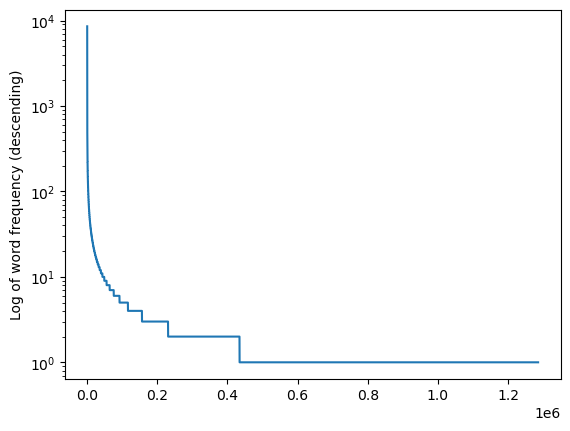

In [3]:
# visualise the frequency distribution

x = np.arange(1, len(surface_co) + 1) # offset by 1
y = np.array(sorted(surface_co.values(), reverse = True))

plt.plot(x, y)
plt.yscale("log")
plt.ylabel("Log of word frequency (descending)")
plt.show()

In [4]:
# filtering out low frequency lemmas and auxiliary verbs

reuters_freq = Counter(chain(*reuters_le)) # unpacks into a counter
# print(len(reuters_freq))
# print(list(reversed(reuters_freq.most_common()))[:10])

filtered_freq = Counter()
filtered_noun_freq = Counter()
stop_verbs = {"be", "have", "do", "would", "will", "could"}

for lemma, freq in reuters_freq.items():
    word, pos = lemma.split('-')

    if freq > 5 and word not in stop_verbs:
        if pos in {"NOUN", "VERB", "ADJ", "ADV"}:
            filtered_freq[lemma] = freq
            
            if pos == "NOUN":
                filtered_noun_freq[lemma] = freq

print(f"{len(filtered_noun_freq)} filtered target items")
print(f"{len(filtered_freq)} filtered context items")

print("\nContexts:")
print(">>", filtered_freq.most_common(15))
print("<<", list(reversed(filtered_freq.most_common()))[:15])

print("\nTargets:")
print(">>", filtered_noun_freq.most_common(15))
print("<<", list(reversed(filtered_noun_freq.most_common()))[:15])

4650 filtered target items
8056 filtered context items

Contexts:
>> [('say-VERB', 27038), ('mln-ADJ', 10500), ('dlrs-NOUN', 9935), ('pct-NOUN', 8501), ('year-NOUN', 8382), ('mln-NOUN', 8071), ('net-ADJ', 6024), ('share-NOUN', 5812), ('company-NOUN', 5535), ('loss-NOUN', 5531), ('bank-NOUN', 4669), ('not-ADV', 4389), ('price-NOUN', 4022), ('market-NOUN', 3623), ('oil-NOUN', 3453)]
<< [('equatorial-NOUN', 6), ('witte-NOUN', 6), ('kadoorie-NOUN', 6), ('bamberger-NOUN', 6), ('messidor-NOUN', 6), ('tseng-NOUN', 6), ('xiamen-NOUN', 6), ('sugarman-NOUN', 6), ('barreto-NOUN', 6), ('tonka-NOUN', 6), ('mamman-NOUN', 6), ('hussein-NOUN', 6), ('dawkins-NOUN', 6), ('alitalia-NOUN', 6), ('gurria-NOUN', 6)]

Targets:
>> [('dlrs-NOUN', 9935), ('pct-NOUN', 8501), ('year-NOUN', 8382), ('mln-NOUN', 8071), ('share-NOUN', 5812), ('company-NOUN', 5535), ('loss-NOUN', 5531), ('bank-NOUN', 4669), ('price-NOUN', 4022), ('market-NOUN', 3623), ('oil-NOUN', 3453), ('profit-NOUN', 3421), ('sale-NOUN', 3281), ('ra

In [5]:
filtered_co = Counter()

for co, freq in surface_co.items():
    if co[0] in filtered_noun_freq and co[1] in filtered_freq:
        filtered_co[co] = freq

print(filtered_co.most_common(20))
print(f"{len(filtered_co)} surface co-occurrences after filtering")

[(('loss-NOUN', 'loss-NOUN'), 8570), (('rev-NOUN', 'mln-ADJ'), 4221), (('dlrs-NOUN', 'dlrs-NOUN'), 4146), (('loss-NOUN', 'net-ADJ'), 4009), (('loss-NOUN', 'mln-ADJ'), 3552), (('dlrs-NOUN', 'mln-NOUN'), 3475), (('mln-NOUN', 'dlrs-NOUN'), 3475), (('shr-NOUN', 'net-ADJ'), 3448), (('profit-NOUN', 'profit-NOUN'), 3080), (('profit-NOUN', 'loss-NOUN'), 2907), (('loss-NOUN', 'profit-NOUN'), 2907), (('rev-NOUN', 'net-ADJ'), 2887), (('mln-NOUN', 'mln-NOUN'), 2878), (('profit-NOUN', 'mln-ADJ'), 2552), (('pct-NOUN', 'pct-NOUN'), 2528), (('profit-NOUN', 'net-ADJ'), 2523), (('share-NOUN', 'dlrs-NOUN'), 2417), (('dlrs-NOUN', 'share-NOUN'), 2417), (('dlrs-NOUN', 'mln-ADJ'), 2382), (('avg-NOUN', 'mln-ADJ'), 2344)]
775024 surface co-occurrences after filtering


<h3> EXPLANATION </h3>

I followed the same preprocessing steps that were demonstrated in Notebook 4 for the most part. I decided early on to remove all lemmas of length 2 or less because the tokenizer produces many such short tokens, such as "'s" or "v".

After lemmatising the Reuters corpus, I proceeded to calculate the surface co-occurrences of lemmas in the corpus, then filter out all auxiliary verbs and infrequent lemmas. A threshold of freq=5 was used for this, as the amount of words that occur less frequently than this overwhelms the dataset. A value higher than 5, however, would limit the dataset too much.

---

# Vector representations (45 points)

## Question 2 (15 points)

Weight the counts in the space you created for the previous question by using the following association measures on both spaces:

1. One **measure of your choice** among those available in the [nltk.BigramAssocMeasures](http://www.nltk.org/howto/metrics.html#association-measures) module.
2. The **Positive Local Mutual Information** measure (as shown in class/lab).

**Possible extra**

3. Also use the **smoothed ppmi measure** proposed by [Levy et al. (2015)](http://www.aclweb.org/anthology/Q15-1016). Recall that the authors proposed to smooth the ppmi by raising the context counts to the power of $\alpha$ (where $\alpha= 0.75$ is reported to work well). That is, if $V_c$ is the vocabulary of all the contexts in a given space and $f(c)$ is the context frequency, they proposed the following association measure:

$$PPMI_\alpha (w,c) = max \left(0, \ log_2 \left(\frac{p(w,c)}{p(w) \cdot p_\alpha(c)}\right)  \right) $$

$$where: \ \ p_\alpha(c) = \frac{f(c)^\alpha}{\sum_{c' \in V_c} f(c')^\alpha}$$

In [6]:
# your code here

# defining the measures chi_sq, plmi, and smoothed ppmi

from nltk.metrics.association import BigramAssocMeasures as BAM
from math import log

def chi_sq(f12: int, f1x: int, fx2: int, fxx: int) -> float:
    """
    Computes the chi-squared score from target-context frequencies
    """
    # unconventional parameter names but
    # helps me understand better
    return round(BAM.chi_sq(f12, (f1x, fx2), fxx), 3)

def plmi(f12: int, f1x: int, fx2: int, fxx: int) -> float:
    """
    Computes PLMI from target-context frequencies
    """
    # return f12 * bam.pmi(f12, (f1x, fx2), fxx)
    
    f12_exp = (f1x * fx2) / fxx
    plmi = f12 * max(0, log(f12 / f12_exp, 2))

    return round(plmi, 3)

def smoothed_ppmi(f12: int, f1x: int, fx2: int, alpha_sum: float, alpha = 0.75) -> float:
    """
    Computes smoothed PPMI from target-context frequencies
    """
    fx2_alpha = (fx2 ** alpha) / alpha_sum
    # print("done here")
    smoothed_ppmi = max(0, log(f12 / (f1x * fx2_alpha), 2))

    return round(smoothed_ppmi, 3)

In [7]:
# applying these measures over the distributional space

N = sum(surface_co.values())
# print(N)
chisq_co = Counter()
plmi_co = Counter()
sppmi_co = Counter()

alpha = 0.75
alpha_sum = sum([freq ** alpha for freq in reuters_freq.values()])

for word, freq in filtered_co.items():
    chisq_co[word] = chi_sq(freq, reuters_freq[word[0]], reuters_freq[word[1]], N)
    plmi_co[word] = plmi(freq, reuters_freq[word[0]], reuters_freq[word[1]], N)
    sppmi_co[word] = smoothed_ppmi(freq, reuters_freq[word[0]], reuters_freq[word[1]], alpha_sum, alpha)

print("Chi-squared scores:")
print(">>", chisq_co.most_common(10))
print("<<", list(reversed(chisq_co.most_common()))[:10])

print("\nPLMI scores:")
print(">>", plmi_co.most_common(10))
print("<<", list(reversed(plmi_co.most_common()))[:10])

print("\nSPPMI scores:")
print(">>", sppmi_co.most_common(10))
print("<<", list(reversed(sppmi_co.most_common()))[:10])

Chi-squared scores:
>> [(('arabica-NOUN', 'cherry-VERB'), 18658123.25), (('robusta-NOUN', 'robusta-NOUN'), 10174752.0), (('loss-NOUN', 'loss-NOUN'), 9551388.233), (('robusta-NOUN', 'cherry-VERB'), 9538826.4), (('ovr-NOUN', 'unc-VERB'), 8723277.727), (('nil-NOUN', 'nil-ADJ'), 7658133.817), (('und-NOUN', 'unc-VERB'), 7246460.859), (('arabica-NOUN', 'arabica-NOUN'), 7065792.0), (('distillery-NOUN', 'corby-ADJ'), 6056392.381), (('ovr-NOUN', 'ovr-NOUN'), 5191192.49)]
<< [(('price-NOUN', 'credit-NOUN'), 0.0), (('credit-NOUN', 'price-NOUN'), 0.0), (('coffee-NOUN', 'net-ADJ'), 0.0), (('rev-NOUN', 'other-ADJ'), 0.0), (('year-NOUN', 'committee-NOUN'), 0.0), (('committee-NOUN', 'year-NOUN'), 0.0), (('loss-NOUN', 'proposal-NOUN'), 0.0), (('proposal-NOUN', 'loss-NOUN'), 0.0), (('output-NOUN', 'share-NOUN'), 0.0), (('share-NOUN', 'output-NOUN'), 0.0)]

PLMI scores:
>> [(('loss-NOUN', 'loss-NOUN'), 86735.033), (('rev-NOUN', 'mln-ADJ'), 39623.51), (('loss-NOUN', 'net-ADJ'), 35686.273), (('shr-NOUN', '

In [8]:
# creating and populating matrices based on our weighted co-occurrence spaces

sorted_target_freq = sorted(filtered_noun_freq)
# rows: target nouns
target_indices = {
    lemma: index
    for index, lemma in enumerate(sorted(filtered_noun_freq))
}
# columns: context words
context_indices = {
    lemma: index
    for index, lemma in enumerate(filtered_freq)
}

surface_co_mat = np.zeros((len(target_indices), len(context_indices)))
chisq_mat = np.zeros((len(target_indices), len(context_indices)))
plmi_mat = np.zeros((len(target_indices), len(context_indices)))
sppmi_mat = np.zeros((len(target_indices), len(context_indices)))

for (target, context), weight in filtered_co.items():
    surface_co_mat[target_indices[target]][context_indices[context]] = weight

for (target, context), weight in chisq_co.items():
    chisq_mat[target_indices[target]][context_indices[context]] = weight

for (target, context), weight in plmi_co.items():
    plmi_mat[target_indices[target]][context_indices[context]] = weight

for (target, context), weight in sppmi_co.items():
    sppmi_mat[target_indices[target]][context_indices[context]] = weight

<h3> EXPLANATION </h3>

For this question, I applied three different measures over the surface co-occurrences to create my distributional spaces, in addition to one based solely on the surface co-occurrences (the extra from the previous question).

From the Bigram Association Measures module, I imported the chi-squared measure to test for independence between target and context items. Then, I implemented the Pointwise Local Mutual Information and Smoothed Positive Pointwise Mutual Information scores, using the suggested value of alpha=0.75 for the latter. In calculating these measures, I took the frequencies over the original, unfiltered corpus in order to better capture the original distribution, even if we're not interested in most of the words within.

Finally, I populate matrices created from these measures in order to build our distributional spaces.

## Question 3 (15 points)

Up to this point, you should have created 2 different distributional spaces (4 if you did the extras).

Use **Singular Value Decomposition** to reduce their dimensionality retaining only the first 100 dimensions. For this question, you can either re-use the SVD code from the lab, or import the SVD functions from external libraries such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) or [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html).

**Possible extra**

Find the 'optimal' number of dimensions to retain using the approach shown in the lab. Use a model with this dimensionality instead of 100.

In [9]:
# your code here

from sklearn.decomposition import TruncatedSVD as TSVD
from sklearn.metrics.pairwise import cosine_similarity

surface_co_tsvd100 = TSVD(n_components = 100, algorithm = "arpack")
surface_co_tsvd100_mat = surface_co_tsvd100.fit_transform(surface_co_mat)

chisq_tsvd100 = TSVD(n_components = 100, algorithm = "arpack")
chisq_tsvd100_mat = chisq_tsvd100.fit_transform(chisq_mat)

plmi_tsvd100 = TSVD(n_components = 100, algorithm = "arpack")
plmi_tsvd100_mat = plmi_tsvd100.fit_transform(plmi_mat)

sppmi_tsvd100 = TSVD(n_components = 100, algorithm = "arpack")
sppmi_tsvd100_mat = sppmi_tsvd100.fit_transform(sppmi_mat)

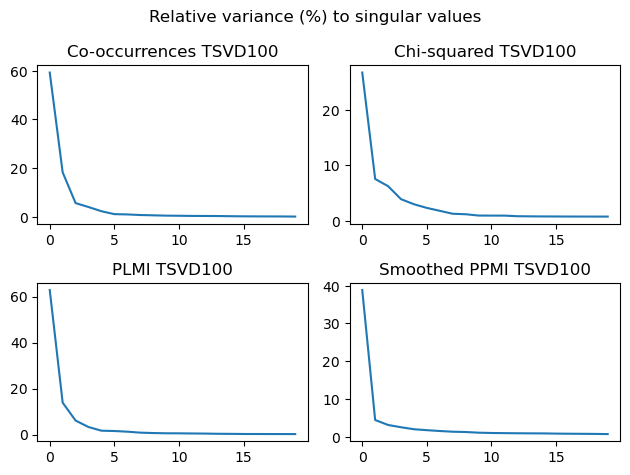

In [10]:
# finding optimal number of dimensions

measure_to_svd = {"Co-occurrences TSVD100" : surface_co_tsvd100,
                  "Chi-squared TSVD100" : chisq_tsvd100,
                 "PLMI TSVD100" : plmi_tsvd100,
                 "Smoothed PPMI TSVD100" : sppmi_tsvd100}

fig, axes = plt.subplots(2, 2)

for i, (measure, svd) in enumerate(measure_to_svd.items()):
    S_sq = svd.singular_values_ ** 2
    explained_var = (S_sq / sum(S_sq)) * 100
    y = explained_var[:20]
    x = np.arange(len(y))

    axes[i // 2][i % 2].plot(x, y, ls = '-')
    axes[i // 2][i % 2].set_title(measure)

fig.suptitle("Relative variance (%) to singular values")
fig.tight_layout()
plt.show()

In [11]:
# using new values for dimensions based on
# the inflection points in scree plot

surface_co_tsvdopt_mat = TSVD(n_components = 5, algorithm = "arpack").fit_transform(surface_co_mat)
chisq_tsvdopt_mat = TSVD(n_components = 7, algorithm = "arpack").fit_transform(chisq_mat)
plmi_tsvdopt_mat = TSVD(n_components = 5, algorithm = "arpack").fit_transform(plmi_mat)
sppmi_tsvdopt_mat = TSVD(n_components = 2, algorithm = "arpack").fit_transform(sppmi_mat)

<h3> EXPLANATION </h3>

In order to reduce the dimensionality of our original distributional spaces, I used scikit-learn's built-in Truncated SVD function to first reduce the dimensions of these matrices to 100. Instead of directly applying TSVD().fit_transform() in one line, I split these two steps into two lines in order to extract the singular values from these models later.

By plotting these singular values against explained variance in a scree plot, we can gain insight into how "relevant" each new component is. Based on the inflection points in these plots, I then trained optimised versions of these models with much fewer components, ranging from 2 to 7.

## Question 4 (15 points)

Train a Word2Vec model on the same corpus, for example using [gensim](https://radimrehurek.com/gensim). Make sure to motivate the choice of your hyperparameters.

**Possible extra**

*Hyperparameter tuning* is the process of finding the optimal hyperparameters in a machine learning task for a given task and data set. Try performing some kind of hyperparameter tuning on your Word2Vec model. Hint: Do this after question 5, so that you'll have a way to know what hyperparameter combination is best.

In [12]:
# your code here

from gensim.models import Word2Vec

params = {
    'vector_size': 20, # dimensions
    'window': 5,
    'epochs': 5,
    'min_count': 5, # same as surface co-occurrences
    'sg': 0, # not the skip-gram (1), use CBOW (0)
    'negative': 5,
    'workers': 4, # how many cores to use
    'alpha': 0.05 # learning rate
}

reuters_word2vec = []
for sentence in reuters_le:
    reuters_word2vec.append([
        token.split('-')[0]
        for token in sentence
        if token in filtered_freq
    ])

cbow_model = Word2Vec(sentences = reuters_word2vec, **params)

<h3> EXPLANATION </h3>

The Word2Vec model is imported from the GenSim library and trained on an untagged version of the Reuters corpus. Most of the hyperparameters were chosen based on gut feeling. I decided to use 20 dimensions as a compromise between 100 dimensions, which would be too sparse, and the greatly reduced values used after optimisation. The value `min-count` was set to 5 in order to match the threshold I used earlier to filter out surface co-occurrences.

---

# Evaluating on semantic similarity (17 points)

## Question 5 (17 points)

Evaluate the performance of your models on a **semantic similarity task**. Using `SimLex-999` as gold standard. Evaluate all of your models on the dataset in `data/SimLex-999.txt`, and determine the best performing model. Note: There should be 5 to 8 model evaluations in total. 5 if you did not do any extra (2 from Q2 + 2 from Q3 + 1 from Q4), and 8 if you did them all (1 from Q1, 3 from Q2 + 3 from Q3 + 2 from Q4).

1. Your evaluation should follow the approach shown in lab 4 (Section 1.6: "Evaluating your Model"), using a **correlation measure** on model predictions and the (human) gold standard. 
2. Remember to **visualize** your results (e.g., as bar plots).
3. Take note (and report) the overlap between your models and the SimLex-999 dataset, i.e., how many pairs are shared by your model and the evaluation dataset.
4. Make sure to discuss your results and provide your reasoning on them.

### Remarks

- The 'SimLex-999' dataset is described in `data/SimLex-999.README.txt`, and [the author's github page](https://fh295.github.io/simlex.html). Hint: the relevant judgements are those in the `SimLex999` column.
- To directly compare the models against the gold standard, you will have to find the *overlap* between them, i.e. the pairs that occur in your model *and* the evaluation dataset.

In [13]:
from scipy.stats import spearmanr as spearmanr

# defining the similarity matrices

surface_co_simmat100 = cosine_similarity(surface_co_tsvd100_mat)
chisq_simmat100 = cosine_similarity(chisq_tsvd100_mat)
plmi_simmat100 = cosine_similarity(plmi_tsvd100_mat)
sppmi_simmat100 = cosine_similarity(sppmi_tsvd100_mat)

surface_co_simmat_opt = cosine_similarity(surface_co_tsvdopt_mat)
chisq_simmat_opt = cosine_similarity(chisq_tsvdopt_mat)
plmi_simmat_opt = cosine_similarity(plmi_tsvdopt_mat)
sppmi_simmat_opt = cosine_similarity(sppmi_tsvdopt_mat)

In [14]:
# filter out only pairs found in the Reuters corpus

pairs_untagged = {
    (item[0].split('-')[0], item[1].split('-')[0])
    for item in filtered_co
}

standard_scores = []
measure_scores = {
    "Co-occurrences TSVD100": (surface_co_simmat100, []),
    "Co-occurrences TSVD5": (surface_co_simmat_opt, []),
    "Chi-squared TSVD100": (chisq_simmat100, []),
    "Chi-squared TSVD7": (chisq_simmat_opt, []),
    "PLMI TSVD100": (plmi_simmat100, []),
    "PLMI TSVD5": (plmi_simmat_opt, []),
    "Smoothed PPMI TSVD100 ": (sppmi_simmat100, []),
    "Smoothed PPMI TSVD2": (sppmi_simmat_opt, []),
}
word2vec_scores = []
measure_rhos = {k: 0 for k in measure_scores.keys()}

with open("data/SimLex-999.txt", 'r') as f:
    next(f) # skip header

    for n, line in enumerate(f.read().split("\n")):
        # enumerate can also be applied to generators like read!

        items = line.split("\t")

        if len(items) > 3:
            target, context = items[0], items[1]
            # we look at SimLex999 scores in the fourth column
            # and normalise by dividing by 10 (max)
            score = round(float(items[3]) / 10, 3)

            if (target, context) in pairs_untagged:
                target_tagged = f"{target}-NOUN"
                # context might not be a noun, so use nltk
                context_tagged = '-'.join(
                    pos_tag([context], tagset = "universal")[0]
                )
                # print(target_tagged, context_tagged)

                target_id = target_indices[target_tagged]
                context_id = context_indices[context_tagged]

                in_flag = True # do we have a score?

                for measure in measure_scores.values():
                    try:
                        measure[1].append(round(measure[0][target_id, context_id], 3))
                    except:
                        in_flag = False
                        break

                if in_flag:
                    # these always have scores
                    standard_scores.append(score)
                    word2vec_scores.append(round(cbow_model.wv.similarity(target, context), 3))

print(f"Found {len(standard_scores)} words in the overlap")

Found 43 words in the overlap


Co-occurrences TSVD100-based space vs. SimLex-999 - Spearman's correlation
0.40732628863517
Co-occurrences TSVD5-based space vs. SimLex-999 - Spearman's correlation
0.2938066498777696
Chi-squared TSVD100-based space vs. SimLex-999 - Spearman's correlation
0.2642015410182807
Chi-squared TSVD7-based space vs. SimLex-999 - Spearman's correlation
0.21736339649573164
PLMI TSVD100-based space vs. SimLex-999 - Spearman's correlation
0.408519323017864
PLMI TSVD5-based space vs. SimLex-999 - Spearman's correlation
0.3385457981640676
Smoothed PPMI TSVD100 -based space vs. SimLex-999 - Spearman's correlation
0.08285498583956638
Smoothed PPMI TSVD2-based space vs. SimLex-999 - Spearman's correlation
0.34780310257019215
Word2Vec-based space vs. SimLex-999 - Spearman's correlation
0.15799411326144935


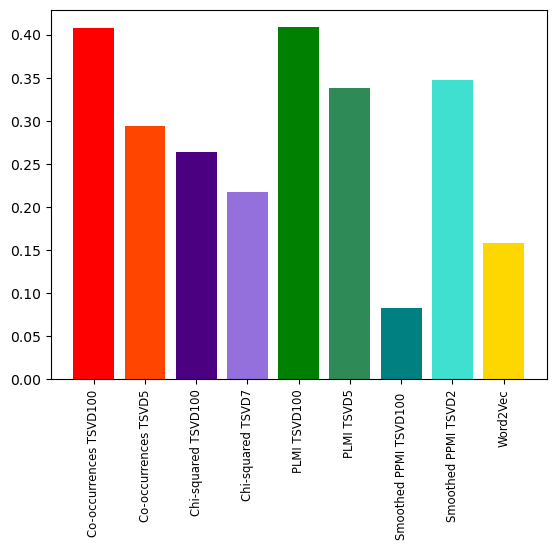

In [15]:
rhos = []

measure_scores["Word2Vec"] = (None, word2vec_scores)
for label, measure in measure_scores.items():
    print(f"{label}-based space vs. SimLex-999 - Spearman's correlation")

    rho = spearmanr(standard_scores, measure[1])[0]
    print(rho)
    rhos.append(rho)

colours = ["red", "orangered", "indigo", "mediumpurple",
           "green", "seagreen", "teal", "turquoise", "gold"]

plt.bar(range(len(rhos)), rhos, color = colours)
plt.xticks(range(len(rhos)), measure_scores.keys(), size = 'small', rotation = 'vertical')
plt.show()

<h3> EXPLANATION </h3>

To evaluate the range of models we've created, I first defined the cosine similarity matrices for each of them except for the Word2Vec model. Then, in order to work with the SimLex-999 data, I had to first define a list of untagged surface co-occurrences to match the ones contained in the SimLex-999 file. Then, whenever there was a match between pairs contained by SimLex-999 and our own surface co-occurrences, I would append the score for said pair from each of our measures if our measures did in fact have a score for it, and ignored it otherwise.

I found only 43 words in the union between the two datasets, which initially surprised me. However, taking a closer look at each corpus revealed that unions between the two were unlikely to begin with. This is because SimLex-999, on the one hand, mostly contains semantically related words, such as synonyms, which might not naturally co-occur in the same short context window; the Reuters corpus, on the other hand, contains only words from a restricted lexical field of news reporting and is not as general as SimLex-999.

Finally, I used Spearman's rank correlation to test if the scores of our measures were correlated with the SimLex-999 standard scoring. As the figure above displays, it seems like the co-occurences and PLMI measures with 100 dimensions performed the best, while the smoothed PPMI with 100 dimensions performed the worst. All "optimised" models seemed to perform slightly worse than their counterparts with 100 dimensions, with the notable exception of the smoothed PPMI measure with only 2 dimensions. In general, all the rho values fell between 0.05 and 0.45, suggesting not a very strong correlation. However, this could also be a bias with the correlation metric itself, as it only measures for a monotonic relationship between variables. If a different correlation test were used, such as Pearson's linear rank, then the results could look different.

---